<a target="_blank" href="https://colab.research.google.com/github/evaalonsoortiz/ELE8812-demos/blob/main/Demos/Lesson%204/Lec%CC%A7on_4_Demo_detr1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ELE8812 - Traitement fréquentiel

## Démo : Détramage par filtrage coupe-bande

### Référence : DIP 4e édition, Chapitre 4, « BANDREJECT AND BANDPASS FILTERS » p.297

L’image utilisée dans ce démo a été digitalisée à partir d’un journal. La technique de digitalisation utilisée a causé un important effet moiré (voir DIP 4e édition p.239 pour une explication en détail de la cause de cet effet). L’effet moiré causé par la digitalisation étant presque parfaitement périodique, il sera possible d’identifier dans la transformée de Fourier (TF) de l’image des régions à intensité élevée correspondant à sa représentation spectrale. Un filtrage sélectif sera ensuite effectué pour atténuer l’effet moiré sans affecter de façon significative le contenu fréquentiel ne correspondant pas à cet artéfact. Plus précisément, 2 filtres coupe-bande de type gaussien seront utilisés.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Option d'affichage
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
!git clone https://github.com/evaalonsoortiz/ELE8812-demos.git Repo

Cloning into 'Repo'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 371 (delta 0), reused 0 (delta 0), pack-reused 362
Receiving objects: 100% (371/371), 37.46 MiB | 10.57 MiB/s, done.
Resolving deltas: 100% (129/129), done.


# Image originale et sa TF

L’effet moiré se manifeste dans le module de la TF de l’image par des pics symétriques de forte intensité éloignés de l’origine. Une transformation logarithmique du module de la TF a été effectuée pour étaler la gamme des valeurs de plus faible intensité et permettre d’avoir un meilleur aperçu du contenu fréquentiel présent dans l’image.

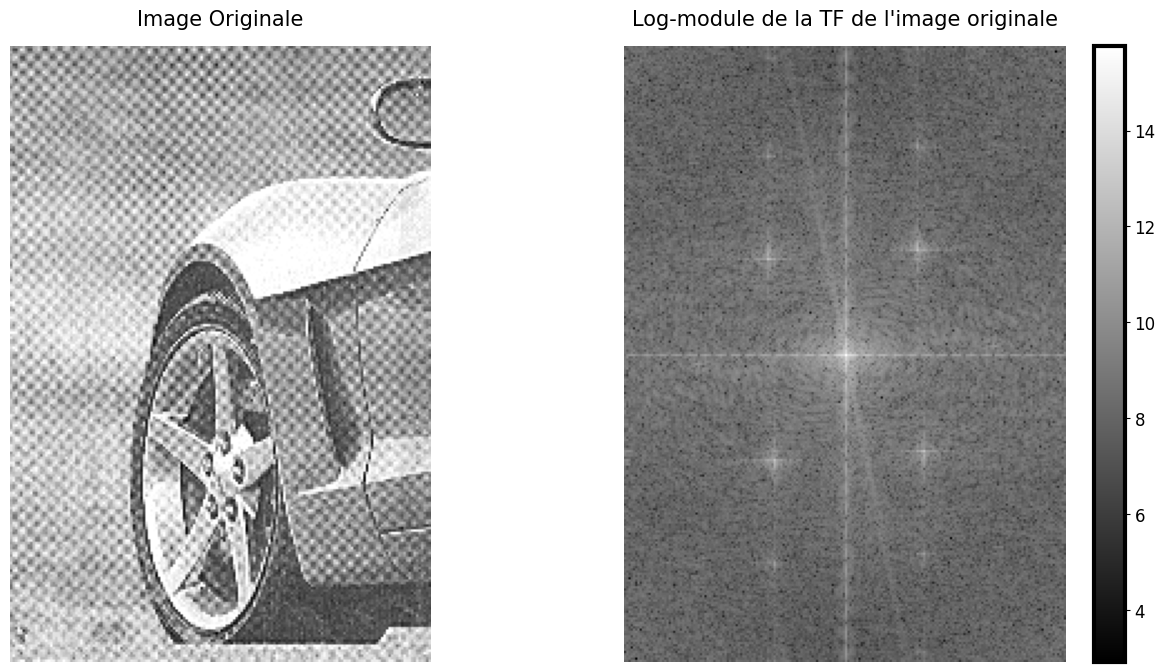

In [3]:
# Charger image
A = plt.imread('Repo/Data/Voiture.tif');

# Transformée de Fourier
pad = 30;
Me, Ne = A.shape
AA = np.fft.fftshift(np.fft.fft2(np.double(A), (Me + pad, Ne + pad)))

plt.subplot(121); plt.imshow(A, cmap='gray'); plt.title('Image Originale'); plt.axis('off');
plt.subplot(122); plt.imshow(np.log(np.abs(AA)), cmap='gray'); plt.colorbar(); plt.title("Log-module de la TF de l'image originale"); plt.axis('off'); plt.show();

# Filtrage coupe-bande

## Paramètres de filtrage

Un filtre coupe-bande peut être construit en combinant un filtre passe-bas et un filtre passe-haut. Un tel filtre « coupe » un bande de fréquences se trouvant à une distance entre d0 et d1 de l’origine. Ceci permet ainsi une plus grande sélectivité qu’un filtre basse-pas ou passe-haut. Les filtres coupe-bande sont généralement définis par la fréquence centrale de la bande coupée (paramètres `fc1` et `fc2` dans l’exemple) ainsi que la largeur de la bande (paramètre `largeur`). À noter que la réponse fréquentielle d’un filtre passe-bande correspond à 1 – la réponse fréquentielle de la version coupe-bande du filtre.

In [4]:
largeur = 20 # largeur de la bande
fc1 = 56.8 # fréquence centrale de la première bande coupée
fc2 = 99.2 # fréquence centrale de la 2e bande coupée

## Représentation du filtre

Dans cet exemple, 2 filtres coupe-bande sont utilisés. Les 2 filtres sont multipliés pour obtenir la représentation fréquentielle ci-dessous (image de gauche). Le filtre combiné est ensuite multiplié à la TF de l’image (le résultat correspond à l’image de droite) avant d’effectuer une TF inverse pour obtenir l’image filtrée.

In [5]:
# Création du filtre
M, N = AA.shape

M0 = np.ceil((M+1) / 2)
N0 = np.ceil((N+1) / 2)

U, V = np.mgrid[1:M+1, 1:N+1]
D2 = (U - M0)**2 + (V - N0)**2

HH1g = 1 - np.exp(- (D2 - fc1**2)**2 / (largeur**2 * D2 ))**2
HH2g = 1 - np.exp(- (D2 - fc2**2)**2 / (largeur**2 * D2 ))**2

# Application du passe bande dans le domaine fréquentiel
BBg = AA * HH1g * HH2g

# Reconstruction de l'image après filtrage
Bg = np.fft.ifft2(np.fft.ifftshift(BBg))

<ipython-input-5-1ac74fcf3fa5>:10: RuntimeWarning: divide by zero encountered in divide
  HH1g = 1 - np.exp(- (D2 - fc1**2)**2 / (largeur**2 * D2 ))**2
<ipython-input-5-1ac74fcf3fa5>:11: RuntimeWarning: divide by zero encountered in divide
  HH2g = 1 - np.exp(- (D2 - fc2**2)**2 / (largeur**2 * D2 ))**2


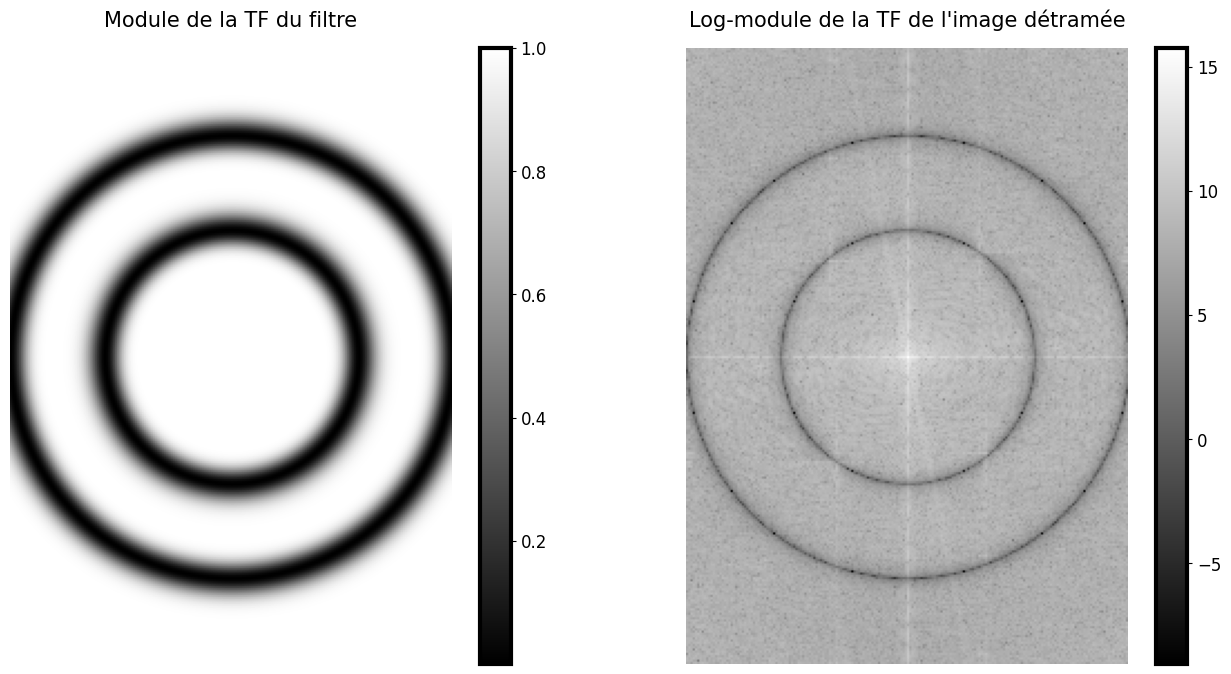

In [6]:
plt.subplot(121); plt.imshow(HH1g*HH2g, cmap='gray'); plt.colorbar(); plt.axis('off'); plt.title('Module de la TF du filtre');
plt.subplot(122); plt.imshow(np.log(np.abs(BBg)), cmap='gray'); plt.colorbar(); plt.axis('off'); plt.title("Log-module de la TF de l'image détramée");
plt.show()

## Résultat

L’effet moiré est encore visible notamment en bordure de l’image et au niveau des contours mais dans l’ensemble le filtrage a permis d’améliorer grandement la qualité de l’image.

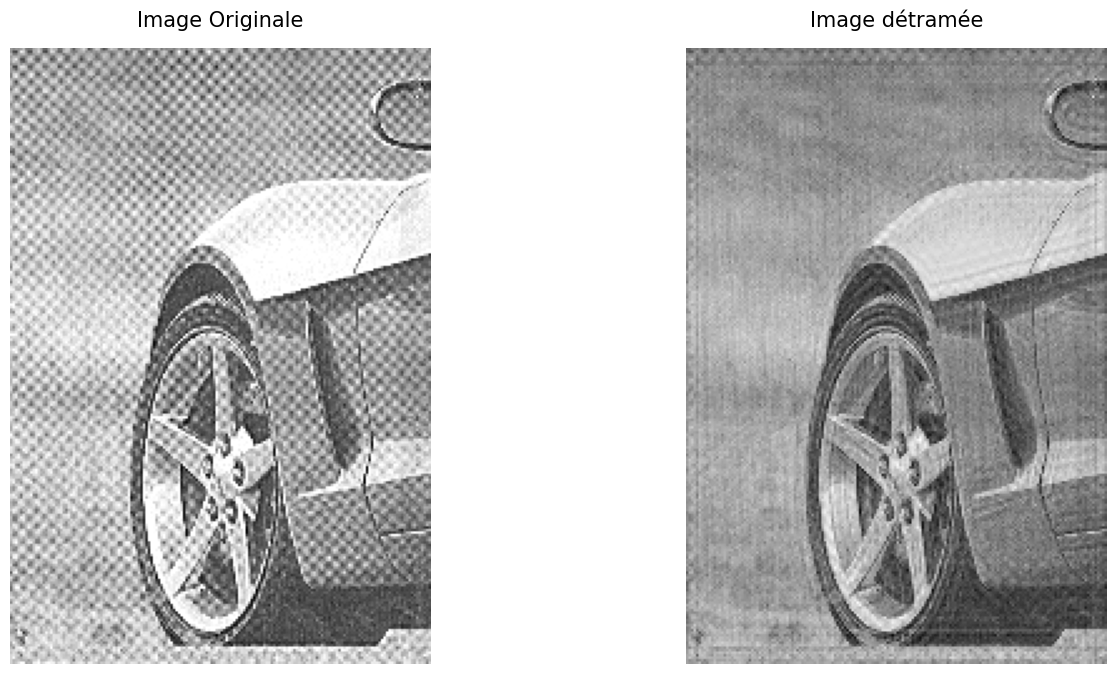

In [7]:
plt.subplot(121); plt.imshow(A, cmap='gray'); plt.title('Image Originale'); plt.axis('off');
plt.subplot(122); plt.imshow(np.real(Bg[:Me,:Ne]), cmap='gray'); plt.axis('off'); plt.title('Image détramée'); plt.show()